In [1]:
from threading import Lock
import warnings
import matplotlib.pyplot as plt
import pyximport
from tqdm import tnrange, tqdm_notebook
from concurrent.futures import ThreadPoolExecutor,as_completed

warnings.filterwarnings('ignore')

import sys
import os

sys.path.insert(0, os.path.join(os.getcwd(), os.pardir))
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

pyximport.install(setup_args={"include_dirs": np.get_include()})
import XXZZham as XXZZham
from XXZZham import add_high_energies, rotate_to_00_base
import random
import adiabatic_sim as asim
import time

import multiprocessing
import ctypes
mkl_rt = ctypes.CDLL('libmkl_rt.so')
mkl_get_max_threads = mkl_rt.mkl_get_max_threads
mkl_rt.mkl_set_num_threads(ctypes.byref(ctypes.c_int(multiprocessing.cpu_count())))
import os
import LH_tools as LHT

%precision %.15f
PRECISION  = 2 ** -40

from IPython.display import display
from functools import reduce
import FD_tools as FDT

In [2]:
class LZ_Ham:
    def __init__(self, delta, omega, A, epsilon0):
        self.delta = delta
        self.omega = omega
        self.A = A
        self.epsilon0 = epsilon0
    
    def getHt(self, t):
        Ht = 1/2 * sigmaz()*(self.A *np.sin(self.omega * t) + self.epsilon0)
        Ht +=1/2* self.delta*sigmax()
        return Ht
    
    def getEV(self, t):
        return [Ht.eigenenergies() for Ht in self.getHt(t)]
    
    def getProp(self, tlist):
        Hts = self.getHt(tlist)
        dt = tlist[1] - tlist[0]
        Uts = [(-1j * Ht * dt).expm() for Ht in Hts]
        U  = reduce((lambda x, y: x * y), Uts)
        return U


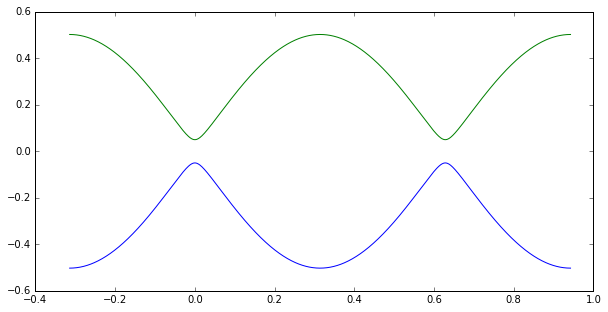

[]


Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = False
Qobj data =
[[ 0.99806195+0.00038008j  0.00000000-0.06222703j]
 [ 0.00000000-0.06222703j  0.99806195-0.00038008j]]

In [242]:
H = LZ_Ham(delta=0.1, omega=5, A=1, epsilon0=0.0)
tlist = np.linspace(-1 / 2, 1.5, 1000) * np.pi/5
Htev = H.getEV(tlist)
plt.figure(figsize=(10, 5))
plt.plot(tlist, Htev)
plt.show()
from scipy.signal import argrelmin, argrelmax
print(tlist[argrelmin(np.array(Htev)[0:, 0])])
prop = H.getProp(tlist)
prop

In [3]:
def _simulate_plz_for_LZ(delta, omega, A=1, epsilon0=0.1):
    H = LZ_Ham(delta=delta, omega=omega, A=A, epsilon0=epsilon0)
    tlist = np.linspace(-1 / 2, 1/2, 300) * np.pi*omega
    prop = H.getProp(tlist)
    Plz = abs(prop[0][0][1])**2
    return Plz

def _simulate_p2_for_LZ(delta, omega, A=1, epsilon0=0.1):
    H = LZ_Ham(delta=delta, omega=omega, A=A, epsilon0=epsilon0)
    tlist = np.linspace(-1 / 2, 1.5, 300) * np.pi*omega
    prop = H.getProp(tlist)
    P2stay = abs(prop[0][0][0])**2
    return P2stay

In [260]:
_simulate_p2_for_LZ(delta=0.1, omega=10, A=1, epsilon0=0.0)

0.999976936706292

In [265]:
from concurrent.futures import ThreadPoolExecutor,as_completed

executor = ThreadPoolExecutor(48)
tasks = []
plt.figure(figsize=(15,15))

P2stays = []
for omega in np.linspace(0.1,30,300):
    tasks.append(
        executor.submit(
            _simulate_p2_for_LZ, 0.1 ,omega
    )
)
results = [simulation.result() for simulation in as_completed(tasks)]
A = np.array(results)


KeyboardInterrupt: 

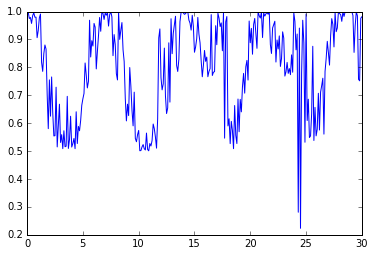

In [270]:
plt.plot(np.linspace(0.1,30,300),A)
plt.show()

In [274]:

executor = ThreadPoolExecutor(48)
tasks = []
plt.figure(figsize=(15,15))

PLZ = []
for omega in np.linspace(0.1,30,300):
    tasks.append(
        executor.submit(
            _simulate_plz_for_LZ, 0.1 ,omega
    )
)
results = [simulation.result() for simulation in as_completed(tasks)]
A = np.array(results)


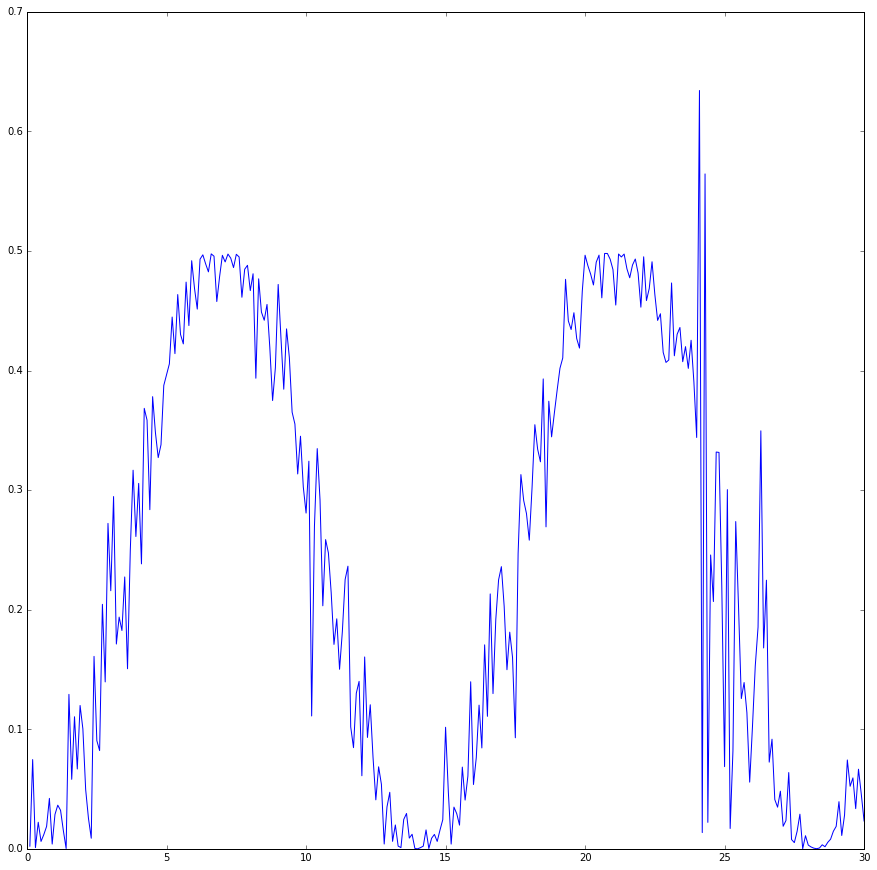

In [275]:
plt.plot(np.linspace(0.1,30,300),A)
plt.show()

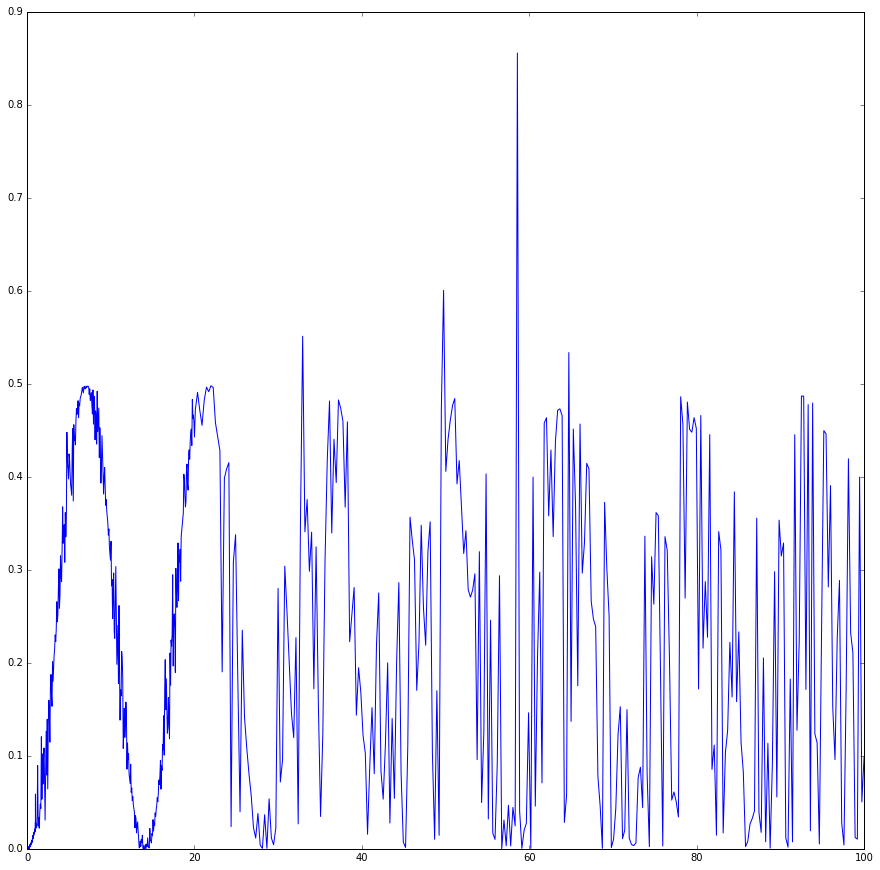

In [4]:
omegas = np.concatenate([np.linspace(0.0001,1,300) , np.linspace(1.01,20,300),np.linspace(20.1,100,300)])


executor = ThreadPoolExecutor(48)
tasks = []
plt.figure(figsize=(15,15))

PLZ = []
for omega in omegas:
    tasks.append(
        executor.submit(
            _simulate_plz_for_LZ, 0.1 ,omega
    )
)
results = [simulation.result() for simulation in as_completed(tasks)]
A = np.array(results)
plt.plot(omegas,A)
plt.show()

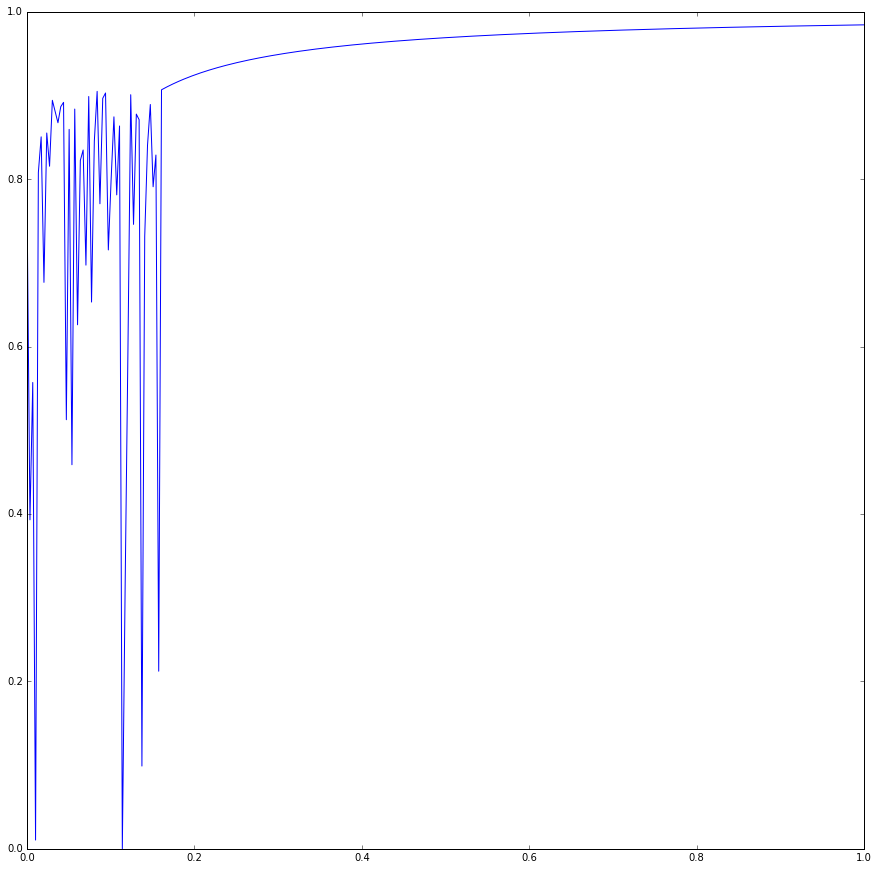

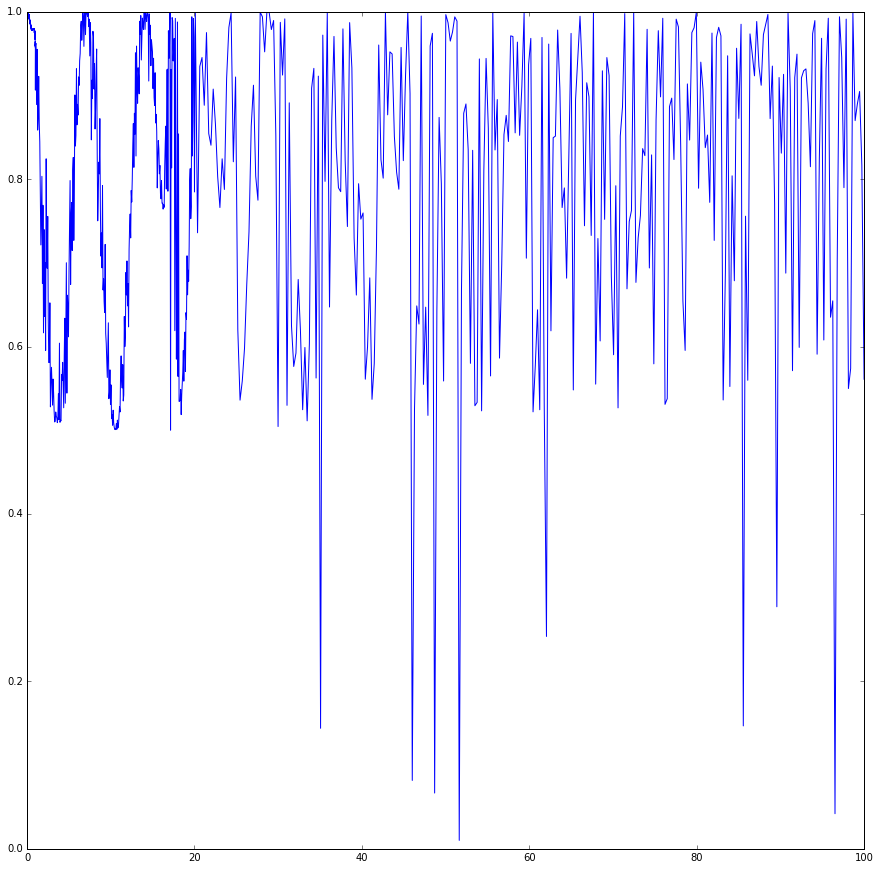

In [4]:
omegas = np.concatenate([np.linspace(0.0001,1,300) , np.linspace(1.01,20,300),np.linspace(20.1,100,300)])


executor = ThreadPoolExecutor(48)
tasks = []
plt.figure(figsize=(15,15))

PLZ = []
for omega in omegas:
    tasks.append(
        executor.submit(
            _simulate_p2_for_LZ, 0.1 ,omega
    )
)
results = [simulation.result() for simulation in as_completed(tasks)]
A = np.array(results)
plt.plot(omegas,A)
plt.show()

In [48]:
one_over_omega = np.linpspace(1,1000,1000)
omegas = 1/one_over_omega
def plz_by_function(delta, omega, A=100, epsilon0=0):
    v = A*omega *np.sqrt(1-(epsilon0/A)**2)
    d = delta**2 / (4*v)
    return np.exp(-2 *np.pi * d)

executor = ThreadPoolExecutor(48)
tasks = []
plt.figure(figsize=(15,15))

PLZ = []
for omega in omegas:
    tasks.append(
        executor.submit(
            plz_by_function, 0.1 ,omega
    )
)
results = [simulation.result() for simulation in as_completed(tasks)]
A = np.array(results)
plt.plot(omegas,A)
plt.ylim([-0.1,1.1])
plt.show()

AttributeError: module 'numpy' has no attribute 'linpspace'